# EEG Classification of Emotions Using CNN, SAE, and DNN

From the paper "EEG-Based Emotion Classification Using a Deep Neural Network and Sparse Autoencoder", they found to have incredibly high recognition accuracy for emotions using EEG data that they put through a Convolutional Recurrent Neural Network, then a Sparse Autoencoder, and finally a Deep Neural Network.

Paper: https://www.frontiersin.org/articles/10.3389/fnsys.2020.00043/full

DEAP Dataset: https://www.eecs.qmul.ac.uk/mmv/datasets/deap/

SEED Dataset: https://bcmi.sjtu.edu.cn/home/seed/seed.html

Output Labels: [-1: "negative", 0: "neutral", 1: "positive"]

## Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import butter, sosfilt
from mlxtend.preprocessing import standardize
import scipy.io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model

## Load Session Recording

- 1 session
- Variable duration = t
- 30 seconds of buffer time in the beginning
- Cut the first 23 seconds so 8 second buffer windows can go through the entire recording
- 128 Hz recording
- 14 EEG Channels

Input Matrix Shape: `1 x 14 x t`

In [3]:
# Set Path of Recording
RECORDING_PATH = "../../../TestData/Recordings/S2/NickVelicer_006_3272023_EPOCX_180417_2023.03.27T14.35.25.05.00.md.bp.csv"

# Set Needed Columns and Recording Rate
EEG_COLUMNS = ["EEG.AF3", "EEG.F7", "EEG.F3", "EEG.FC5", "EEG.T7", "EEG.P7", "EEG.O1", "EEG.O2", "EEG.P8", "EEG.T8", "EEG.FC6", "EEG.F4", "EEG.F8", "EEG.AF4"]
HZ = 128

# Import data but skip the first line (metadata)
df = pd.read_csv(RECORDING_PATH, skiprows=[0])
# Select subsection of EEG electrode recordings
df = df[EEG_COLUMNS]
# Drop the first 30 seconds of buffer time
df = df.iloc[(HZ * 23):]
# Convert to numpy 2D array
df = df.to_numpy()
# Standardize 2D array
df = standardize(df)
# Expand dimension of transposed data
raw = np.expand_dims(df.T, axis=0)

# Print Shape
print("data Shape:", raw.shape)

data Shape: (1, 14, 38441)


## Band-Pass Filter Functions

In [4]:
# Functions from: https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butterhttps://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
# Params from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='bandpass', output='sos')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y

## General Band-Pass Filter

- This is used to get rid of general noise
- Done across the Hz range 0.1-45

Input Matrix Shape: `1 x 14 x t`

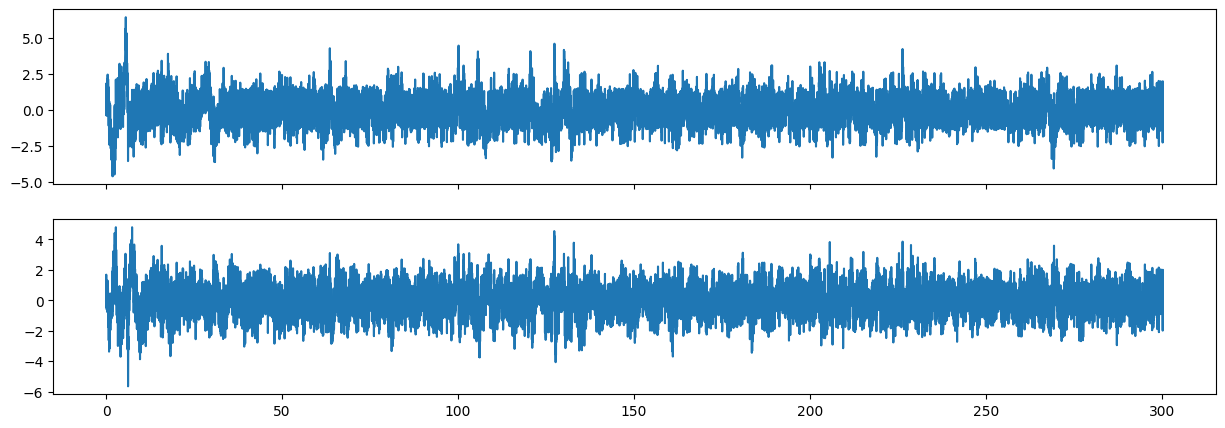

filterData Shape: (1, 14, 38441)


In [5]:
# Filter Params
LOWCUT = 0.1
HIGHCUT = 45.0
ORDER = 9

# Bool for plotting first filter
plotData = True
# Initialize empty matrix to put all filtered data into
filterData = np.zeros_like(raw)

# Iterate through each epoch/recording
for idx in range(raw.shape[0]):
    # Get the epoch of the index
    epoch = raw[idx]
    # Initialize empty matrix to put filtered epoch data into
    filteredEpoch = np.zeros_like(epoch)

    # Iterate through the rows of the epoch/recording
    # Each row is a 1D vector of one electrodes values
    for i in range(epoch.shape[0]):
        # Get the row of the index
        channel = epoch[i]
        # Use the butterworth bandpass filter from 0.1-45 Hz
        filtered = butter_bandpass_filter(channel, LOWCUT, HIGHCUT, HZ, order=ORDER)

        # Test plotting the filtered data
        if (plotData):
            t = np.linspace(0, len(channel)/HZ, len(channel), False) # timesteps for 80@200Hz
            fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,5))
            ax1.plot(t, channel)
            ax2.plot(t, filtered)
            plt.show()
            plotData = False
        
        # Add filtered channel into the filterEpoch matrix
        filteredEpoch[i] = filtered
    
    # Add filtered epoch into the filterData matrix
    filterData[idx] = filteredEpoch

print("filterData Shape:", filterData.shape)

## Butterworth Band-Pass Filter

- $\alpha$ (1-7 Hz), $\beta$ (8-13 Hz), $\theta$ (14-30 Hz), $\lambda$ (30-45 Hz)
- This will break up the single stream of data from each channel into 4 streams of separate bands

Input Matrix Shape: `1 x 4 x 14 x t`

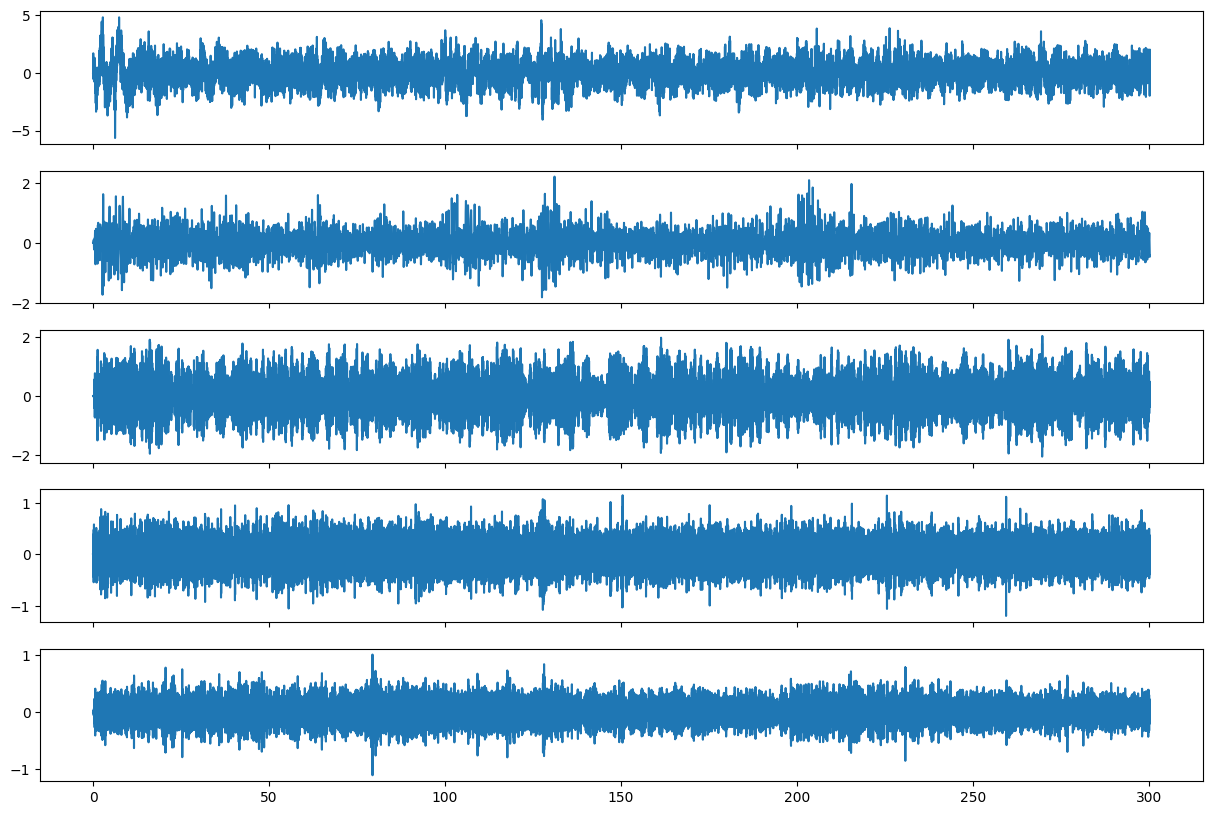

bandData Shape: (1, 4, 14, 38441)


In [6]:
# Filter Params
ALPHA = (1, 7)
BETA = (8, 13)
THETA = (14, 30)
LAMBDA = (30, 45)
ORDER = 9

# Bool for plotting first filter
plotData = True
# Initialize empty list to put all epoched band data into
bandData = []

# Iterate through each filtered epoch/recording
for idx in range(filterData.shape[0]):
    # Get the epoch of the index
    epoch = filterData[idx]
    # Initialize empty matrixs to put band data into
    alphaData = np.zeros_like(epoch)
    betaData = np.zeros_like(epoch)
    thetaData = np.zeros_like(epoch)
    lambdaData = np.zeros_like(epoch)

    # Iterate through the rows of the filtered epoch/recording
    # Each row is a 1D vector of one electrodes values
    for i in range(epoch.shape[0]):
        # Get the row of the index
        channel = epoch[i]
        # Use the butterworth bandpass filter for each band on a channel
        alphaChan = butter_bandpass_filter(channel, ALPHA[0], ALPHA[1], HZ, order=ORDER)
        betaChan = butter_bandpass_filter(channel, BETA[0], BETA[1], HZ, order=ORDER)
        thetaChan = butter_bandpass_filter(channel, THETA[0], THETA[1], HZ, order=ORDER)
        lambdaChan = butter_bandpass_filter(channel, LAMBDA[0], LAMBDA[1], HZ, order=ORDER)

        # Test plotting the filtered data
        if (plotData):
            t = np.linspace(0, len(channel)/HZ, len(channel), False) # timesteps for 80@200Hz
            fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(15,10))
            ax1.plot(t, channel)
            ax2.plot(t, alphaChan)
            ax3.plot(t, betaChan)
            ax4.plot(t, thetaChan)
            ax5.plot(t, lambdaChan)
            plt.show()
            plotData = False

        # Add each band channel vector into its respective matrix
        alphaData[i] = alphaChan
        betaData[i] = betaChan
        thetaData[i] = thetaChan
        lambdaData[i] = lambdaChan
    
    # Initialize list of band data
    epochBandData = [alphaData, betaData, thetaData, lambdaData]
    # Take the list of 2D numpy arrays and
    # convert it to 3D matrix
    epochBandData = np.stack(epochBandData)
    # Append the epochBandData to bandData list
    bandData.append(epochBandData)

# Take the list of 3D numpy arrays and 
# convert it to 4D matrix
bandData = np.stack(bandData)

print("bandData Shape:", bandData.shape)

## Epoch the Epochs

- Break up the recording into 8 second segments, moving every second.
- (128 * t) => (128 * 8)
- (128 * t) => 1024

Input Matrix Shape: `t x 4 x 14 x 1024`

In [7]:
# Initialize empty lists to put all 8 seconds epochs and new labels into respectively
epochData = []

# Iterate through each filtered band epoch/recording
for idx in range(bandData.shape[0]):
    # Get the epoch of the index
    epoch = bandData[idx]

    # Iterrate through 8 second time intervals 
    for t in range(0, epoch.shape[2], HZ*1):
        # Break if 8 seconds goes past end of recording
        if (t + HZ*8 > epoch.shape[2]):
            break

        # Initialize empty matrix to put 8 s epoch into (4, 14, 1024)
        epoch8 = np.zeros((epoch.shape[0], epoch.shape[1], HZ*8))

        # Iterate through each band in the epoch
        for i in range(epoch.shape[0]):
            # Add the time interval from this
            # band into the epoch8 matrix
            epoch8[i] = epoch[i,:,t:t+HZ*8]

        # Append 8 second epoch to epochData list
        epochData.append(epoch8)


# Take the list of 3D numpy arrays and 
# convert it to 4D matrix
epochData = np.stack(epochData)

print("epochData Shape:", epochData.shape)

epochData Shape: (293, 4, 14, 1024)


## PCC Feature Extraction

- PCC (Pearson Correlation Coefficient)
- On every band and epoch
- Basically calculating correlation of every channel pair against each other
- (14 x 1024) => (14 x 14)

Input Matrix Shape: `t x 4 x 14 x 14`

In [8]:
# Initialize empty list to put the PCC data into
pccData = []

print("epochData Shape:", epochData.shape)
# Iterate through each epoch
for idx in range(epochData.shape[0]):
    # Get the epoch of the index
    epoch = epochData[idx]
    # Initialize empty list to put the epoch PCC data into
    pccEpoch = []
    
    # Iterate through each band
    for i in range(epoch.shape[0]):
        # Get the band of the index
        band = epoch[i]
        # Extract PCC from the band
        pcc = np.corrcoef(band)
        # Append PCC features into pccEpoch list
        pccEpoch.append(pcc)

    # Take the list of 2D numpy arrays and
    # convert it to 3D matrix
    pccEpoch = np.stack(pccEpoch)
    # Append the pccEpoch to pccData list
    pccData.append(pccEpoch)
    
# Take the list of 3D numpy arrays and
# convert it to 4D matrix
pccData = np.stack(pccData)

print("pccData Shape:", pccData.shape)


epochData Shape: (293, 4, 14, 1024)
pccData Shape: (293, 4, 14, 14)


# Reshape to Multi-Image Format

- 4 x 14 x 14 ==> 14 x 14 x 2
- This is the format that works for images with rgb values
    - A 2D matrix with 3 rgb values (n x m x 3)
    - We have a 2D matrix with 4 bands of data

Input Matrix Shape: `t x 14 x 14 x 4`

In [9]:
# Initialize empty list to put reshaped data into
reshapedData = [np.transpose(i, (1, 2, 0)) for i in pccData]
reshapedData = np.stack(reshapedData)

print("reshapedData Shape:", reshapedData.shape)

reshapedData Shape: (293, 14, 14, 4)


# Load in the Trained Models

In [10]:
# Load in CNN Model
CNN_model = load_model("CNNModel.2.0.h5")
CNN_model.load_weights("CNNWeights.2.0")
CNN_model.summary()

# Load in SAE Model
SAE_model = load_model("SAEModel.2.0.h5")
SAE_model.load_weights("SAEWeights.2.0")
SAE_model.summary()

# Load in DNN Model
DNN_model = load_model("DNNModel.2.0.h5")
DNN_model.load_weights("DNNWeights.2.0")
DNN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 14, 14, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 12, 14, 32)        416       
                                                                 
 dropout (Dropout)           (None, 12, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 14, 64)        6208      
                                                                 
 dropout_1 (Dropout)         (None, 10, 14, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 4, 64)         0         
 )                                                               
                                                             

2023-04-02 11:17:14.224638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "Sparse-Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SAE-Input-Layer (InputLayer  [(None, 512)]            0         
 )                                                               
                                                                 
 SAE-Encoder-Hidden-Layer (D  (None, 512)              262656    
 ense)                                                           
                                                                 
 SAE-Bottleneck-Layer (Dense  (None, 128)              65664     
 )                                                               
                                                                 
 SAE-Decoder-Output-Layer (D  (None, 512)              66048     
 ense)                                                           
                                                                 
Total params: 394,368
Trainable params: 39

# Run Session through Models

In [11]:
# Get output of CNN Model
CNN_out = CNN_model.predict(reshapedData)
# Get output of SAE Model
SAE_out = SAE_model.predict(CNN_out)
# Get output of DNN Model
out = DNN_model.predict(SAE_out)

print("CNN Output Shape:", CNN_out.shape)
print("SAE Output Shape:", SAE_out.shape)
print("DNN Output Shape:", out.shape)

10/10 [==============================] - 0s 984us/step
CNN Output Shape: (293, 512)
SAE Output Shape: (293, 512)
DNN Output Shape: (293, 3)


# Argmax and Save Model Predictions

In [16]:
predictions = np.argmax(out, axis=1)
valence = np.random.random(predictions.shape[0])
arousal = np.random.random(predictions.shape[0])
df = pd.DataFrame(valence)
df["a"] = arousal
df["p"] = predictions
print(valence)
print(predictions)
print(df)

[3.83952337e-01 2.77949167e-01 4.77541934e-01 2.74530350e-01
 5.76120393e-01 9.19327733e-01 2.76141292e-01 1.09028151e-01
 9.68740737e-01 3.28544838e-01 1.40303077e-01 9.49534830e-01
 6.81844965e-01 9.66567044e-01 5.15449354e-02 8.14331103e-01
 3.79886351e-01 5.57599852e-01 5.03605274e-01 5.34478054e-02
 1.39902554e-01 8.73578002e-01 1.34857141e-01 9.69937760e-01
 8.86885427e-01 6.69192419e-01 5.22088259e-01 3.86703593e-01
 6.43007629e-01 6.73281777e-02 4.60046313e-01 6.97583817e-01
 3.21920679e-01 5.32359550e-01 8.10365685e-01 3.24307454e-02
 2.21203481e-01 7.23231090e-01 4.85718698e-02 1.23575376e-01
 5.55810177e-01 9.84034060e-01 7.89560377e-01 1.32732300e-01
 6.59870030e-02 5.65588366e-01 3.88192958e-01 1.66463180e-01
 5.02278003e-01 5.97998652e-01 3.93626825e-01 7.78721025e-02
 2.03163837e-01 8.60477547e-01 1.26829933e-02 3.83592386e-01
 6.68253907e-01 7.45151107e-01 5.32984908e-01 7.58694636e-02
 9.94051774e-01 4.59342208e-01 5.91768291e-01 3.69054903e-01
 4.31973168e-01 1.510898